<a href="https://colab.research.google.com/github/yosbel-penate/AppEFThreading/blob/master/Clasificador_imagenes_ropa_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [68]:
datos,metadatos=tfds.load('fashion_mnist', as_supervised=True, with_info=True)

In [69]:
datos_entrenamiento, datos_prueba=datos['train'], datos['train']

In [70]:
nombres_clases=metadatos.features['label'].names

In [71]:
def normalizar(imagenes, etiquetas):
  imagenes=tf.cast(imagenes, tf.float32)
  imagenes /=255
  return imagenes, etiquetas

In [72]:
datos_entrenamiento=datos_entrenamiento.map(normalizar)
datos_prueba=datos_prueba.map(normalizar)

In [73]:
datos_entrenamiento=datos_entrenamiento.cache()
datos_prueba=datos_prueba.cache()

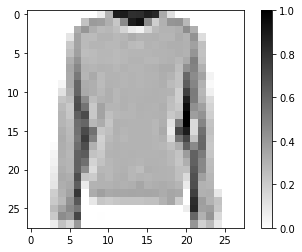

In [74]:
for imagen, etiqueta in datos_entrenamiento.take(1):
  break
imagen=imagen.numpy().reshape(28,28)

import matplotlib.pyplot as plt
plt.figure()
plt.imshow(imagen, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

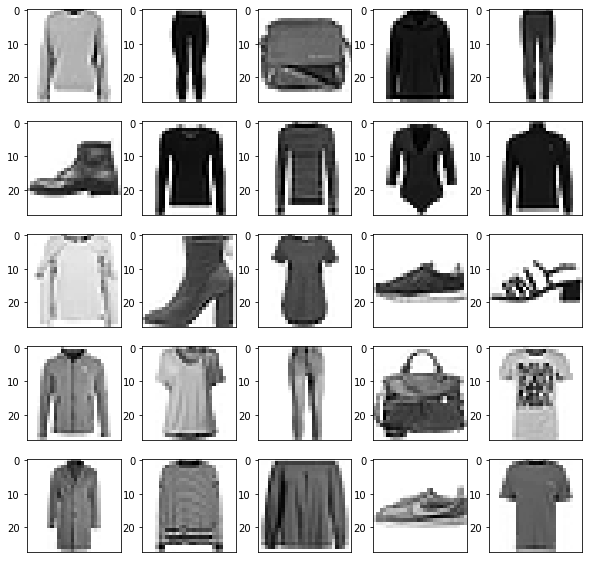

In [75]:
plt.figure(figsize=(10, 10))
for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):
  imagen=imagen.numpy().reshape((28, 28))
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.xticks([])
  plt.grid(False)
  plt.imshow(imagen, cmap=plt.cm.binary)

plt.show()

In [76]:
modelo =tf.keras.Sequential([
                             tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
                             tf.keras.layers.Dense(50, activation=tf.nn.relu),
                             tf.keras.layers.Dense(50, activation=tf.nn.relu),
                             tf.keras.layers.Dense(10, activation=tf.nn.softmax),
])

In [78]:
modelo.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [82]:
num_ej_entrenamiento=metadatos.splits["train"].num_examples
num_ej_pruebas=metadatos.splits["test"].num_examples
print(num_ej_entrenamiento)
print(num_ej_pruebas)

60000
10000


In [83]:
TAMANO_LOTE=32
datos_entrenamiento=datos_entrenamiento.repeat().shuffle(num_ej_entrenamiento).batch(TAMANO_LOTE)
datos_prueba=datos_prueba.batch(TAMANO_LOTE)

In [84]:
import math
historial=modelo.fit(datos_entrenamiento, epochs=5, steps_per_epoch=math.ceil(num_ej_entrenamiento/TAMANO_LOTE))

Epoch 1/5
1875/1875 [==============================] - 11s 2ms/step - loss: 0.5122 - accuracy: 0.8181
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3823 - accuracy: 0.8628
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3473 - accuracy: 0.8732
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3253 - accuracy: 0.8801
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3096 - accuracy: 0.8853


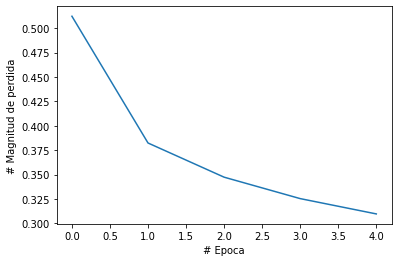

In [85]:
plt.xlabel("# Epoca")
plt.ylabel("# Magnitud de perdida")
plt.plot(historial.history["loss"])